In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import glob
import pickle

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import tqdm

import autobl.steering
from autobl.steering.configs import *
from autobl.steering.measurement import *
from autobl.steering.acquisition import *
from autobl.steering.optimization import *
from autobl.util import *

torch.set_default_device('cpu')

In [2]:
set_random_seed(123)
plot_graphs = True

In [3]:
data_path = 'data/raw/LiTiO_XANES/dataanalysis/Originplots/Sample1_50C_XANES.csv'

In [4]:
data_all_spectra = pd.read_csv(data_path, header=None)
data_all_spectra

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,4936.000000,4936.500000,4937.000000,4937.500000,4938.000000,4938.500000,4939.000000,4939.500000,4940.000000,4940.50000,...,5001.50000,5002.00000,5002.50000,5003.00000,5003.50000,5004.00000,5004.50000,5005.00000,5005.50000,5006.00000
1,0.005420,-0.000265,0.001830,0.003960,0.000507,0.002170,0.004290,0.001660,0.008580,0.00457,...,1.34627,1.33542,1.32561,1.30748,1.27745,1.25692,1.22866,1.19840,1.16776,1.13832
2,0.000399,0.001930,0.003800,0.001530,0.001090,0.003250,0.000448,0.000324,0.006140,0.00445,...,1.33703,1.32843,1.31673,1.30007,1.27325,1.24884,1.21725,1.19444,1.16368,1.13456
3,0.004960,0.007110,0.001490,0.000174,0.000674,0.002970,0.004700,0.001770,0.003300,0.00433,...,1.33959,1.32791,1.31768,1.29564,1.27382,1.25032,1.22341,1.19401,1.16089,1.13613
4,0.003510,0.002480,0.000983,0.000178,0.000705,0.002130,0.005450,-0.000759,0.001930,0.00311,...,1.33333,1.32914,1.31438,1.29633,1.27064,1.24557,1.22360,1.19474,1.16229,1.13286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.003510,0.002610,0.000659,-0.002530,-0.002550,0.003750,0.004680,-0.004530,0.000895,0.00416,...,1.22189,1.24877,1.25049,1.24624,1.23297,1.21781,1.20075,1.18945,1.17262,1.15319
125,-0.000972,-0.003700,-0.001510,-0.008560,-0.005030,-0.000713,-0.000946,-0.004490,0.001080,-0.00203,...,1.22255,1.22380,1.23450,1.23352,1.22399,1.20301,1.19104,1.17716,1.16057,1.14369
126,0.003660,0.001200,-0.000220,0.003630,0.003010,0.003860,0.000327,-0.000153,0.006030,0.00173,...,1.22356,1.23407,1.24095,1.23811,1.22552,1.21022,1.19423,1.18404,1.16565,1.14718
127,0.000999,0.000135,0.000794,-0.000515,0.000775,0.002160,-0.000492,-0.000762,-0.000787,-0.00152,...,1.21150,1.21795,1.22707,1.22468,1.21487,1.20169,1.18085,1.16794,1.15274,1.13740


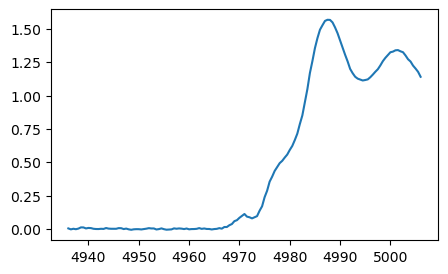

In [5]:
data = data_all_spectra.iloc[len(data_all_spectra) // 2].to_numpy()
energies = data_all_spectra.iloc[0].to_numpy()
energies = torch.tensor(energies)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), data)
plt.show()

Utility functions for analysis

In [6]:
def rms(actual, true):
    return np.sqrt(np.mean((actual - true) ** 2))

def create_intermediate_figure(n_target_measurements, n_plot_interval=20):
    n_plots = int(np.ceil(n_target_measurements / n_plot_interval))
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)
    return fig, ax

def update_intermediate_figure(guide, energies, data, n_measured, i_plot, axes):
    n_rows = len(axes)
    n_cols = len(axes[0])
    # guide.plot_posterior(energies)
    guide.plot_posterior(energies, ax=axes[i_plot // n_cols][i_plot % n_cols])
    axes[i_plot // n_cols][i_plot % n_cols].plot(to_numpy(energies), data, label='Truth', color='gray', alpha=0.6)
    axes[i_plot // n_cols][i_plot % n_cols].set_title('{} points'.format(n_measured))
    axes[i_plot // n_cols][i_plot % n_cols].legend()

def create_intermediate_data_dict(energies, data):
    intermediate_data_dict = {
        'energies': to_numpy(energies),
        'data': to_numpy(data),
        'n_measured_list': [],
        'mu_list': [],
        'sigma_list': []
    }
    return intermediate_data_dict

def update_intermediate_data_dict(guide, config, n_measured, intermediate_data_dict):
    mu, sigma = guide.get_posterior_mean_and_std(energies[:, None])
    mu = mu.squeeze()
    sigma = sigma.squeeze()
    intermediate_data_dict['n_measured_list'].append(n_measured)
    intermediate_data_dict['mu_list'].append(to_numpy(mu))
    intermediate_data_dict['sigma_list'].append(to_numpy(sigma))
    return intermediate_data_dict

def save_intermediate_data_dict(intermediate_data_dict, config, guide, save_dir):
    fname = get_save_name_prefix(config, guide)
    fname = fname + '_intermediate_data.pkl'
    fname = os.path.join(save_dir, fname)
    pickle.dump(intermediate_data_dict, open(fname, 'wb'))

def create_convergence_figure_and_data():
    fig, ax = plt.subplots(1, 1)
    return fig, ax, [], []

def update_convergence_data(guide, n_measured, n_measured_list, metric_list):
    mu, _ = guide.get_posterior_mean_and_std(energies[:, None])
    mu = mu.squeeze()
    metric = rms(mu.detach().cpu().numpy(), data)
    n_measured_list.append(n_measured)
    metric_list.append(metric)
    return n_measured_list, metric_list

def plot_convergence(fig, ax, n_measured_list, metric_list):
    ax.plot(n_measured_list, metric_list)
    ax.set_xlabel('Points measured')
    ax.set_ylabel('RMS')

def get_save_name_prefix(config, guide):
    data_name = os.path.splitext(os.path.basename(data_path))[0]
    
    acquisition_info = config.acquisition_function_class.__name__
    if config.acquisition_function_class in [GradientAwarePosteriorStandardDeviation, FittingResiduePosteriorStandardDeviation]:
        acquisition_info += '_phi_{}'.format(guide.acquisition_function.phi)
    if config.acquisition_function_class == ComprehensiveAigmentedAcquisitionFunction:
        acquisition_info += '_gradOrder_{}_phiG_{}_phiR_{}'.format(guide.acquisition_function.gradient_order, guide.acquisition_function.phi_g, guide.acquisition_function.phi_r)
        if guide.acquisition_function.gradient_order == 2:
            acquisition_info += '_phiG2_{}'.format(guide.acquisition_function.phi_g2)
        
    kernel_info = '{}_lengthscale_{:.3f}'.format(guide.model.covar_module.__class__.__name__, 
                                                 guide.unscale_by_normalizer_bounds(
                                                     guide.model.covar_module.lengthscale.item()
                                                 ))
    if isinstance(guide.model.covar_module, gpytorch.kernels.MaternKernel):
        kernel_info += '_nu_{}'.format(guide.model.covar_module.nu)

    optimizer_info = config.optimizer_class.__name__

    save_name_prefix = '_'.join([data_name, acquisition_info, kernel_info, optimizer_info])
    return save_name_prefix

Creating a common config template:

In [7]:
config = XANESExperimentGuideConfig(
        dim_measurement_space=1,
        num_candidates=1,
        model_class=botorch.models.SingleTaskGP,
        model_params={'covar_module': gpytorch.kernels.MaternKernel(2.5)},
        override_kernel_lengthscale=7,
        noise_variance=1e-6,
        lower_bounds=torch.tensor([energies[0]]),
        upper_bounds=torch.tensor([energies[-1]]),
        n_updates_create_acqf_mask_func=5,
        acqf_mask_floor_value=0.1,
        acqf_mask_post_edge_gain=3.0,
    
        # optimizer_class=ContinuousOptimizer,
        # optimizer_params={'num_restarts': 2,}
        #                   #'options': {'maxiter': 2}}
    
        # optimizer_class=DiscreteOptimizer,
        # optimizer_params={'optim_func': botorch.optim.optimize.optimize_acqf_discrete, 
        #                   'optim_func_params': {
        #                       'choices': torch.linspace(0, 1, len(energies))[:, None]
        #                   }
        #                  }
    
        optimizer_class=TorchOptimizer,
        optimizer_params={'torch_optimizer': torch.optim.Adam, 'torch_optimizer_options': {'maxiter': 20}}
)

In [8]:
instrument = SimulatedMeasurement(data=(energies[None, :], data))

Sample 10 points with equal spacing to initialize.

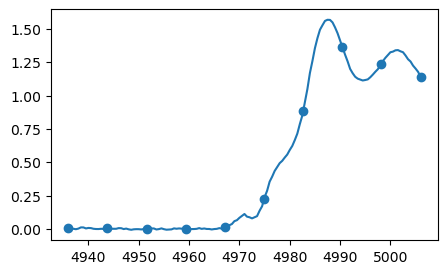

In [9]:
n_init = 10
x_init = torch.linspace(energies[0], energies[-1], n_init).double().reshape(-1, 1)
y_init = instrument.measure(x_init).reshape(-1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), to_numpy(data))
ax.scatter(to_numpy(x_init), to_numpy(y_init))
plt.show()

In [10]:
def run_simulated_experiment(config, x_init, y_init, n_target_measurements=None):
    guide = autobl.steering.guide.XANESExperimentGuide(config)
    guide.build(x_init, y_init)

    if n_target_measurements is None:
        n_target_measurements = len(data) - n_init
    n_plot_interval = 5
    n_measured = n_init

    if plot_graphs:
        fig_intermediate, axes_intermediate = create_intermediate_figure(n_target_measurements, n_plot_interval)
        fig_conv, axes_conv, n_measured_list, metric_list = create_convergence_figure_and_data()
        intermediate_data_dict = create_intermediate_data_dict(energies, data)
        i_plot = 0
    for i in tqdm.trange(n_target_measurements):
        candidates = guide.suggest().double()
        y_new = instrument.measure(candidates).unsqueeze(-1)
        guide.update(candidates, y_new)
        n_measured += len(candidates)
        if plot_graphs:
            intermediate_data_dict = update_intermediate_data_dict(guide, config, n_measured, intermediate_data_dict)
            if i % n_plot_interval == 0:
                update_intermediate_figure(guide, energies, data, n_measured, i_plot, axes_intermediate)
                i_plot += 1
            update_convergence_data(guide, n_measured, n_measured_list, metric_list)

    if plot_graphs:
        plot_convergence(fig_conv, axes_conv, n_measured_list, metric_list)
        fig_intermediate.savefig(os.path.join('outputs', get_save_name_prefix(config, guide) + '_intermediate.pdf'), bbox_inches='tight')
        fig_conv.savefig(os.path.join('outputs', get_save_name_prefix(config, guide) + '_conv.pdf'))
        np.savetxt(os.path.join('outputs', get_save_name_prefix(config, guide) + '_conv.txt'), np.stack([n_measured_list, metric_list]))
        save_intermediate_data_dict(intermediate_data_dict, config, guide, 'outputs')

# Experiments with different acquisition functions

## Posterior standard deviation

In [ ]:
config.acquisition_function_class = PosteriorStandardDeviation
config.acquisition_function_params = {}

In [ ]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=70)

## Gradient-aware posterior standard deviation

In [ ]:
config.acquisition_function_class = GradientAwarePosteriorStandardDeviation
config.acquisition_function_params = {'phi': 1e-2, 'method': 'numerical', 'order': 2}

In [ ]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=70)

## Acquisition function with reference spectra

Given the spectra expected at the beginning and end of a dynamic experiment, a spectrum measured at some point in between can be approximated by a linear combination between the beginning and end spectra. 

We design an acquisition function where the current posterior mean is linearly fit with the beginning and end spectra as bases, and the fitting residue is calculated and returned as the acquisition function value. 

In [11]:
ref_spectra_0 = torch.tensor(data_all_spectra.iloc[1].to_numpy())
ref_spectra_1 = torch.tensor(data_all_spectra.iloc[-1].to_numpy())
ref_spectra_y = torch.stack([ref_spectra_0, ref_spectra_1], dim=0)
ref_spectra_x = torch.linspace(0, 1, ref_spectra_y.shape[-1])

# config.acquisition_function_class = FittingResiduePosteriorStandardDeviation
# config.acquisition_function_params = {'reference_spectra_x': ref_spectra_x, 
#                                       'reference_spectra_y': ref_spectra_y, 
#                                       'phi': 100}
config.acquisition_function_class = ComprehensiveAigmentedAcquisitionFunction
config.acquisition_function_params = {'gradient_order': 2,
                                      'differentiation_method': 'numerical',
                                      'reference_spectra_x': ref_spectra_x, 
                                      'reference_spectra_y': ref_spectra_y, 
                                      'phi_r': 1e1,
                                      'phi_g': 1e-2,
                                      'phi_g2': 1e-4,
                                      'addon_term_lower_bound': 1e-2,
                                      'debug': False}

[2024-04-16 17:21:34,678] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-16 17:21:34,753] Kernel lengthscale after optimization (normalized & standardized): [[0.29607319]]
[2024-04-16 17:21:34,756] Kernel lengthscale overriden to: 7 (0.09999999999999999 after normalization)


0.01


  1%|█                                                                          | 1/70 [00:02<02:46,  2.42s/it]

0.01


  3%|██▏                                                                        | 2/70 [00:03<01:31,  1.34s/it]

0.0099


  4%|███▏                                                                       | 3/70 [00:03<01:07,  1.01s/it]

0.009801


  6%|████▎                                                                      | 4/70 [00:03<00:50,  1.32it/s]

0.00970299


[2024-04-16 17:21:39,567] Building acquisition function mask with floor value 0.1.
  7%|█████▎                                                                     | 5/70 [00:04<00:47,  1.36it/s]

0.0096059601


  9%|██████▍                                                                    | 6/70 [00:05<00:41,  1.56it/s]

0.009509900499


 10%|███████▌                                                                   | 7/70 [00:05<00:40,  1.56it/s]

0.00941480149401


 11%|████████▌                                                                  | 8/70 [00:06<00:38,  1.60it/s]

0.0093206534790699


 13%|█████████▋                                                                 | 9/70 [00:06<00:33,  1.82it/s]

0.0092274469442792


 14%|██████████▌                                                               | 10/70 [00:07<00:29,  2.02it/s]

0.009135172474836408


 16%|███████████▋                                                              | 11/70 [00:07<00:28,  2.08it/s]

0.009043820750088045


 17%|████████████▋                                                             | 12/70 [00:08<00:28,  2.01it/s]

0.008953382542587164


 19%|█████████████▋                                                            | 13/70 [00:08<00:30,  1.85it/s]

0.008863848717161293


 20%|██████████████▊                                                           | 14/70 [00:09<00:28,  2.00it/s]

0.008775210229989679


 21%|███████████████▊                                                          | 15/70 [00:09<00:25,  2.15it/s]

0.008687458127689783


 23%|████████████████▉                                                         | 16/70 [00:10<00:29,  1.85it/s]

0.008600583546412884


 24%|█████████████████▉                                                        | 17/70 [00:10<00:26,  2.00it/s]

0.008514577710948755


 26%|███████████████████                                                       | 18/70 [00:11<00:24,  2.12it/s]

0.008429431933839267


 27%|████████████████████                                                      | 19/70 [00:11<00:23,  2.20it/s]

0.008345137614500875


 29%|█████████████████████▏                                                    | 20/70 [00:12<00:26,  1.86it/s]

0.008261686238355867


 30%|██████████████████████▏                                                   | 21/70 [00:12<00:28,  1.73it/s]

0.008179069375972308


 31%|███████████████████████▎                                                  | 22/70 [00:13<00:29,  1.63it/s]

0.008097278682212584


 33%|████████████████████████▎                                                 | 23/70 [00:14<00:27,  1.73it/s]

0.00801630589539046


 34%|█████████████████████████▎                                                | 24/70 [00:14<00:24,  1.89it/s]

0.007936142836436554


 36%|██████████████████████████▍                                               | 25/70 [00:14<00:22,  2.01it/s]

0.007856781408072187


 37%|███████████████████████████▍                                              | 26/70 [00:15<00:22,  1.94it/s]

0.007778213593991467


 39%|████████████████████████████▌                                             | 27/70 [00:15<00:20,  2.05it/s]

0.007700431458051551


 40%|█████████████████████████████▌                                            | 28/70 [00:16<00:19,  2.14it/s]

0.007623427143471036


 41%|██████████████████████████████▋                                           | 29/70 [00:16<00:20,  2.03it/s]

0.007547192872036326


 43%|███████████████████████████████▋                                          | 30/70 [00:17<00:20,  1.92it/s]

0.007471720943315961


 44%|████████████████████████████████▊                                         | 31/70 [00:18<00:21,  1.80it/s]

0.007397003733882802


 46%|█████████████████████████████████▊                                        | 32/70 [00:18<00:21,  1.79it/s]

0.007323033696543975


 47%|██████████████████████████████████▉                                       | 33/70 [00:19<00:19,  1.93it/s]

0.007249803359578534


 49%|███████████████████████████████████▉                                      | 34/70 [00:19<00:17,  2.04it/s]

0.00717730532598275


 50%|█████████████████████████████████████                                     | 35/70 [00:19<00:16,  2.11it/s]

0.007105532272722921


 51%|██████████████████████████████████████                                    | 36/70 [00:20<00:16,  2.12it/s]

0.007034476949995692


 53%|███████████████████████████████████████                                   | 37/70 [00:20<00:15,  2.18it/s]

0.006964132180495734


 54%|████████████████████████████████████████▏                                 | 38/70 [00:21<00:14,  2.22it/s]

0.006894490858690777


 56%|█████████████████████████████████████████▏                                | 39/70 [00:21<00:14,  2.19it/s]

0.006825545950103869


 57%|██████████████████████████████████████████▎                               | 40/70 [00:22<00:13,  2.17it/s]

0.006757290490602831


 59%|███████████████████████████████████████████▎                              | 41/70 [00:22<00:13,  2.14it/s]

0.006689717585696803


 60%|████████████████████████████████████████████▍                             | 42/70 [00:23<00:14,  1.88it/s]

0.0066228204098398346


 61%|█████████████████████████████████████████████▍                            | 43/70 [00:23<00:14,  1.90it/s]

0.006556592205741436


 63%|██████████████████████████████████████████████▌                           | 44/70 [00:24<00:13,  2.00it/s]

0.006491026283684022


 64%|███████████████████████████████████████████████▌                          | 45/70 [00:24<00:12,  2.04it/s]

0.0064261160208471816


 66%|████████████████████████████████████████████████▋                         | 46/70 [00:25<00:11,  2.04it/s]

0.00636185486063871


 67%|█████████████████████████████████████████████████▋                        | 47/70 [00:25<00:11,  1.96it/s]

0.006298236312032322


 69%|██████████████████████████████████████████████████▋                       | 48/70 [00:26<00:12,  1.70it/s]

0.006235253948912


 70%|███████████████████████████████████████████████████▊                      | 49/70 [00:27<00:11,  1.79it/s]

0.00617290140942288


 71%|████████████████████████████████████████████████████▊                     | 50/70 [00:27<00:11,  1.76it/s]

0.00611117239532865


 73%|█████████████████████████████████████████████████████▉                    | 51/70 [00:28<00:11,  1.68it/s]

0.006050060671375364


 74%|██████████████████████████████████████████████████████▉                   | 52/70 [00:28<00:10,  1.74it/s]

0.00598956006466161


 76%|████████████████████████████████████████████████████████                  | 53/70 [00:29<00:10,  1.56it/s]

0.005929664464014994


 77%|█████████████████████████████████████████████████████████                 | 54/70 [00:30<00:10,  1.52it/s]

0.0058703678193748445


 79%|██████████████████████████████████████████████████████████▏               | 55/70 [00:30<00:09,  1.66it/s]

0.005811664141181096


 80%|███████████████████████████████████████████████████████████▏              | 56/70 [00:31<00:08,  1.67it/s]

0.005753547499769285


 81%|████████████████████████████████████████████████████████████▎             | 57/70 [00:31<00:07,  1.73it/s]

0.005696012024771592


 83%|█████████████████████████████████████████████████████████████▎            | 58/70 [00:32<00:06,  1.83it/s]

0.005639051904523875


 84%|██████████████████████████████████████████████████████████████▎           | 59/70 [00:32<00:05,  1.90it/s]

0.005582661385478637


 86%|███████████████████████████████████████████████████████████████▍          | 60/70 [00:33<00:05,  1.95it/s]

0.005526834771623851


 87%|████████████████████████████████████████████████████████████████▍         | 61/70 [00:33<00:04,  1.94it/s]

0.005471566423907613


 89%|█████████████████████████████████████████████████████████████████▌        | 62/70 [00:34<00:04,  1.98it/s]

0.0054168507596685355


 90%|██████████████████████████████████████████████████████████████████▌       | 63/70 [00:35<00:03,  1.83it/s]

0.00536268225207185


 91%|███████████████████████████████████████████████████████████████████▋      | 64/70 [00:35<00:03,  1.90it/s]

0.005309055429551132


 93%|████████████████████████████████████████████████████████████████████▋     | 65/70 [00:36<00:03,  1.59it/s]

0.00525596487525562


 94%|█████████████████████████████████████████████████████████████████████▊    | 66/70 [00:37<00:02,  1.47it/s]

0.005203405226503064


 96%|██████████████████████████████████████████████████████████████████████▊   | 67/70 [00:37<00:01,  1.60it/s]

0.005151371174238033


 97%|███████████████████████████████████████████████████████████████████████▉  | 68/70 [00:38<00:01,  1.68it/s]

0.005099857462495653


 99%|████████████████████████████████████████████████████████████████████████▉ | 69/70 [00:38<00:00,  1.54it/s]

0.005048858887870696


100%|██████████████████████████████████████████████████████████████████████████| 70/70 [00:39<00:00,  1.76it/s]

0.004998370298991989


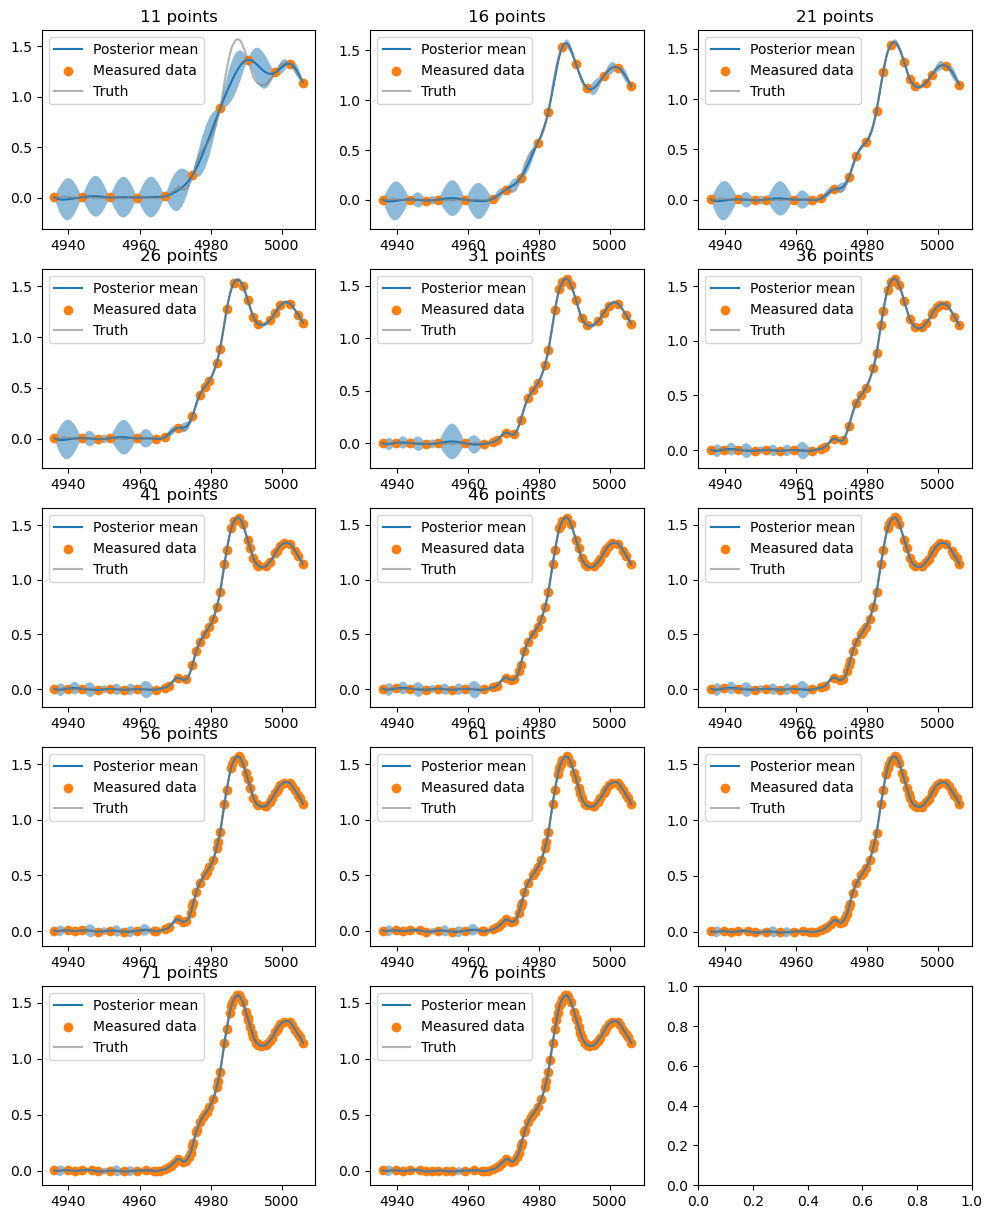

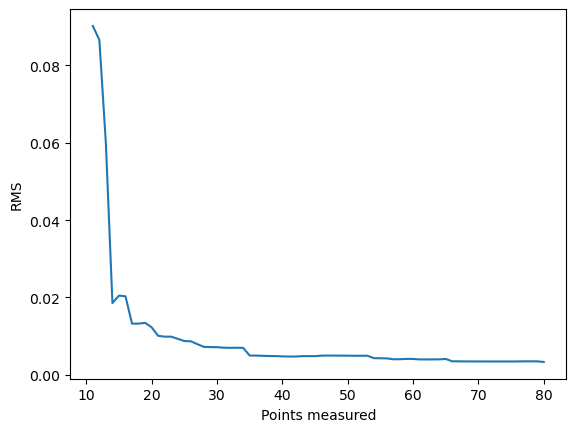

In [12]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=70)

 # Overall experiment with acquisition functions, acquisition parameters, and kernel parameters

In [ ]:
config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(2.5)}
for acquisition_class in [PosteriorStandardDeviation, GradientAwarePosteriorStandardDeviation]:
    if acquisition_class == GradientAwarePosteriorStandardDeviation:
        config.acquisition_function_params = {'phi': 1e-3}
    else:
        config.acquisition_function_params = {}
    for ls in [3.5, 7.0, 14.0]:
        config.acquisition_function_class = acquisition_class
        config.override_kernel_lengthscale = ls
        run_simulated_experiment(config, x_init, y_init)

config.override_kernel_lengthscale = 7.0
for acquisition_class in [PosteriorStandardDeviation, GradientAwarePosteriorStandardDeviation]:
    if acquisition_class == GradientAwarePosteriorStandardDeviation:
        config.acquisition_function_params = {'phi': 1e-3}
    else:
        config.acquisition_function_params = {}
    for nu in [2.5, 1.5, 0.5]:
        config.acquisition_function_class = acquisition_class
        config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(nu)}
        run_simulated_experiment(config, x_init, y_init)

config.override_kernel_lengthscale = 7.0
config.acquisition_function_class = GradientAwarePosteriorStandardDeviation
config.model_params = {'covar_module': gpytorch.kernels.MaternKernel(2.5)}
for phi in [1e-3, 1e-2]:
    config.acquisition_function_params = {'phi': phi}
    run_simulated_experiment(config, x_init, y_init)

## Combine convergence plots

In [ ]:
def combine_convergence_plots(data_dir='outputs/gradient_acquisition'):
    flist = sorted(glob.glob(os.path.join(data_dir, '*_conv.txt')))
    fig, ax = plt.subplots(1, 1)
    for fname in flist:
        name = os.path.basename(fname)
        name = name[:name.find('_conv.txt')]
        data = np.loadtxt(fname)
        ax.plot(data[0], data[1], label=name)
    ax.set_xlabel('Points measured')
    ax.set_ylabel('RMS')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    plt.tight_layout()
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), frameon=False, ncol=1)
    plt.savefig(os.path.join(data_dir, 'combined_conv_plots.pdf'), bbox_inches='tight')

In [ ]:
combine_convergence_plots()

# YBCO data

In [14]:
data_path = 'data/raw/YBCO/YBCO3data.csv'
data_all_spectra = pd.read_csv(data_path, header=0)
# Only keep 8920 - 9080 eV
data_all_spectra = data_all_spectra.iloc[14:232]
data_all_spectra

,energy,YBCO_epara.0001,YBCO_eparc.0001,YBCO_epararb.0001
14,8921.3895,-0.000731,-0.000159,-0.001650
15,8931.5417,-0.000229,-0.000714,-0.001560
16,8941.6316,0.000681,0.000286,-0.001462
17,8951.6931,0.001454,0.001234,-0.000006
18,8961.8816,0.003856,0.003720,0.002051
...,...,...,...,...
227,9073.6476,1.029671,1.031639,1.028860
228,9075.4923,1.023071,1.035609,1.026010
229,9077.4265,1.012816,1.033167,1.019481
230,9079.2550,1.002068,1.025874,1.009070


In [15]:
def linear_fit(basis_list, data):
    a = np.stack([to_numpy(ref_spectra_0), to_numpy(ref_spectra_1)]).T
    b = data.reshape(-1, 1)
    x = np.linalg.pinv(a) @ b
    y_fit = (a @ x).reshape(-1)
    return y_fit

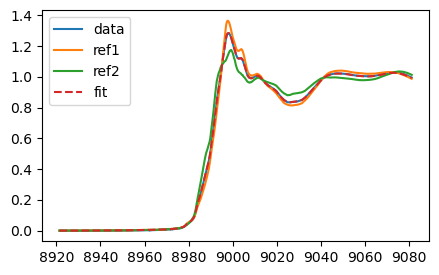

In [16]:
data = data_all_spectra['YBCO_epararb.0001'].to_numpy()
ref_spectra_0 = torch.tensor(data_all_spectra['YBCO_epara.0001'].to_numpy())
ref_spectra_1 = torch.tensor(data_all_spectra['YBCO_eparc.0001'].to_numpy())
energies = data_all_spectra['energy'].to_numpy()
energies = torch.tensor(energies)
y_fit = linear_fit([to_numpy(ref_spectra_0), to_numpy(ref_spectra_1)], data)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), data, label='data')
ax.plot(to_numpy(energies), to_numpy(ref_spectra_0), label='ref1')
ax.plot(to_numpy(energies), to_numpy(ref_spectra_1), label='ref2')
ax.plot(to_numpy(energies), y_fit, label='fit', linestyle='--')
plt.legend()
plt.show()

In [17]:
instrument = SimulatedMeasurement(data=(energies[None, :], data))

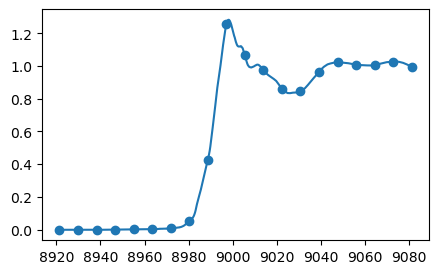

In [18]:
n_init = 20
x_init = torch.linspace(energies[0], energies[-1], n_init).double().reshape(-1, 1)
y_init = instrument.measure(x_init).reshape(-1, 1)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(to_numpy(energies), to_numpy(data))
ax.scatter(to_numpy(x_init), to_numpy(y_init))
plt.show()

In [19]:
ref_spectra_y = torch.stack([ref_spectra_0, ref_spectra_1], dim=0)
ref_spectra_x = torch.linspace(0, 1, ref_spectra_y.shape[-1])

config = XANESExperimentGuideConfig(
        dim_measurement_space=1,
        num_candidates=1,
        model_class=botorch.models.SingleTaskGP,
        model_params={'covar_module': gpytorch.kernels.MaternKernel(2.5)},
        noise_variance=1e-6,
        override_kernel_lengthscale=7,
        lower_bounds=torch.tensor([energies[0]]),
        upper_bounds=torch.tensor([energies[-1]]),
    
        # optimizer_class=ContinuousOptimizer,
        # optimizer_params={'num_restarts': 2,}
        #                   #'options': {'maxiter': 2}}
    
        # optimizer_class=DiscreteOptimizer,
        # optimizer_params={'optim_func': botorch.optim.optimize.optimize_acqf_discrete, 
        #                   'optim_func_params': {
        #                       'choices': torch.linspace(0, 1, len(energies))[:, None]
        #                   }
        #                  }
    
        optimizer_class=TorchOptimizer,
        optimizer_params={'torch_optimizer': torch.optim.Adam, 'torch_optimizer_options': {'maxiter': 20}},
        n_updates_create_acqf_mask_func=5,
        acqf_mask_floor_value=0.1,
        acqf_mask_post_edge_gain=3.0
)

config.acquisition_function_class = ComprehensiveAigmentedAcquisitionFunction
config.acquisition_function_params = {'gradient_order': 2,
                                      'differentiation_method': 'numerical',
                                      'reference_spectra_x': ref_spectra_x, 
                                      'reference_spectra_y': ref_spectra_y, 
                                      'phi_r': 1e1,
                                      'phi_g': 1e-2, #2e-2,
                                      'phi_g2': 1e-4, #3e-4
                                      'addon_term_lower_bound': 1e-2,
                                      'debug': False
                                     }

[2024-04-16 17:16:22,807] Kernel lengthscale before optimization (normalized & standardized): [[0.69314718]]
[2024-04-16 17:16:22,898] Kernel lengthscale after optimization (normalized & standardized): [[0.10491803]]
[2024-04-16 17:16:22,900] Kernel lengthscale overriden to: 7 (0.04377511511731585 after normalization)


0.01


  2%|█▌                                                                         | 1/50 [00:00<00:21,  2.33it/s]

0.01


  4%|███                                                                        | 2/50 [00:01<00:24,  1.93it/s]

0.0099


  6%|████▌                                                                      | 3/50 [00:01<00:27,  1.73it/s]

0.009801


  8%|██████                                                                     | 4/50 [00:02<00:24,  1.89it/s]

0.00970299


[2024-04-16 17:16:25,586] Building acquisition function mask with floor value 0.1.
 10%|███████▌                                                                   | 5/50 [00:02<00:22,  2.04it/s]

0.0096059601


 12%|█████████                                                                  | 6/50 [00:02<00:21,  2.09it/s]

0.009509900499


 14%|██████████▌                                                                | 7/50 [00:03<00:19,  2.19it/s]

0.00941480149401


 16%|████████████                                                               | 8/50 [00:04<00:21,  1.95it/s]

0.0093206534790699


 18%|█████████████▌                                                             | 9/50 [00:04<00:19,  2.07it/s]

0.0092274469442792


 20%|██████████████▊                                                           | 10/50 [00:05<00:21,  1.85it/s]

0.009135172474836408


 22%|████████████████▎                                                         | 11/50 [00:05<00:21,  1.85it/s]

0.009043820750088045


 24%|█████████████████▊                                                        | 12/50 [00:06<00:19,  1.93it/s]

0.008953382542587164


 26%|███████████████████▏                                                      | 13/50 [00:06<00:18,  1.96it/s]

0.008863848717161293


 28%|████████████████████▋                                                     | 14/50 [00:07<00:17,  2.02it/s]

0.008775210229989679


 30%|██████████████████████▏                                                   | 15/50 [00:07<00:19,  1.75it/s]

0.008687458127689783


 32%|███████████████████████▋                                                  | 16/50 [00:08<00:22,  1.49it/s]

0.008600583546412884


 34%|█████████████████████████▏                                                | 17/50 [00:09<00:22,  1.48it/s]

0.008514577710948755


 36%|██████████████████████████▋                                               | 18/50 [00:09<00:19,  1.64it/s]

0.008429431933839267


 38%|████████████████████████████                                              | 19/50 [00:10<00:17,  1.77it/s]

0.008345137614500875


 40%|█████████████████████████████▌                                            | 20/50 [00:10<00:15,  1.88it/s]

0.008261686238355867


 42%|███████████████████████████████                                           | 21/50 [00:11<00:15,  1.92it/s]

0.008179069375972308


 44%|████████████████████████████████▌                                         | 22/50 [00:11<00:14,  1.94it/s]

0.008097278682212584


 46%|██████████████████████████████████                                        | 23/50 [00:12<00:13,  1.97it/s]

0.00801630589539046


 48%|███████████████████████████████████▌                                      | 24/50 [00:12<00:12,  2.03it/s]

0.007936142836436554


 50%|█████████████████████████████████████                                     | 25/50 [00:13<00:12,  2.08it/s]

0.007856781408072187


 52%|██████████████████████████████████████▍                                   | 26/50 [00:13<00:13,  1.73it/s]

0.007778213593991467


 54%|███████████████████████████████████████▉                                  | 27/50 [00:14<00:12,  1.85it/s]

0.007700431458051551


 56%|█████████████████████████████████████████▍                                | 28/50 [00:14<00:11,  1.89it/s]

0.007623427143471036


 58%|██████████████████████████████████████████▉                               | 29/50 [00:15<00:11,  1.75it/s]

0.007547192872036326


 60%|████████████████████████████████████████████▍                             | 30/50 [00:16<00:10,  1.82it/s]

0.007471720943315961


 62%|█████████████████████████████████████████████▉                            | 31/50 [00:16<00:10,  1.87it/s]

0.007397003733882802


 64%|███████████████████████████████████████████████▎                          | 32/50 [00:17<00:09,  1.87it/s]

0.007323033696543975


 66%|████████████████████████████████████████████████▊                         | 33/50 [00:17<00:08,  1.92it/s]

0.007249803359578534


 68%|██████████████████████████████████████████████████▎                       | 34/50 [00:18<00:08,  1.94it/s]

0.00717730532598275


 70%|███████████████████████████████████████████████████▊                      | 35/50 [00:18<00:07,  1.93it/s]

0.007105532272722921


 72%|█████████████████████████████████████████████████████▎                    | 36/50 [00:19<00:08,  1.60it/s]

0.007034476949995692


 74%|██████████████████████████████████████████████████████▊                   | 37/50 [00:20<00:08,  1.45it/s]

0.006964132180495734


 76%|████████████████████████████████████████████████████████▏                 | 38/50 [00:20<00:07,  1.53it/s]

0.006894490858690777


 78%|█████████████████████████████████████████████████████████▋                | 39/50 [00:21<00:06,  1.59it/s]

0.006825545950103869


 80%|███████████████████████████████████████████████████████████▏              | 40/50 [00:22<00:06,  1.62it/s]

0.006757290490602831


 82%|████████████████████████████████████████████████████████████▋             | 41/50 [00:22<00:05,  1.66it/s]

0.006689717585696803


 84%|██████████████████████████████████████████████████████████████▏           | 42/50 [00:23<00:04,  1.72it/s]

0.0066228204098398346


 86%|███████████████████████████████████████████████████████████████▋          | 43/50 [00:23<00:03,  1.76it/s]

0.006556592205741436


 88%|█████████████████████████████████████████████████████████████████         | 44/50 [00:24<00:03,  1.84it/s]

0.006491026283684022


 90%|██████████████████████████████████████████████████████████████████▌       | 45/50 [00:24<00:02,  1.91it/s]

0.0064261160208471816


 92%|████████████████████████████████████████████████████████████████████      | 46/50 [00:25<00:02,  1.64it/s]

0.00636185486063871


 94%|█████████████████████████████████████████████████████████████████████▌    | 47/50 [00:26<00:01,  1.61it/s]

0.006298236312032322


 96%|███████████████████████████████████████████████████████████████████████   | 48/50 [00:26<00:01,  1.72it/s]

0.006235253948912


 98%|████████████████████████████████████████████████████████████████████████▌ | 49/50 [00:27<00:00,  1.80it/s]

0.00617290140942288


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.81it/s]

0.00611117239532865


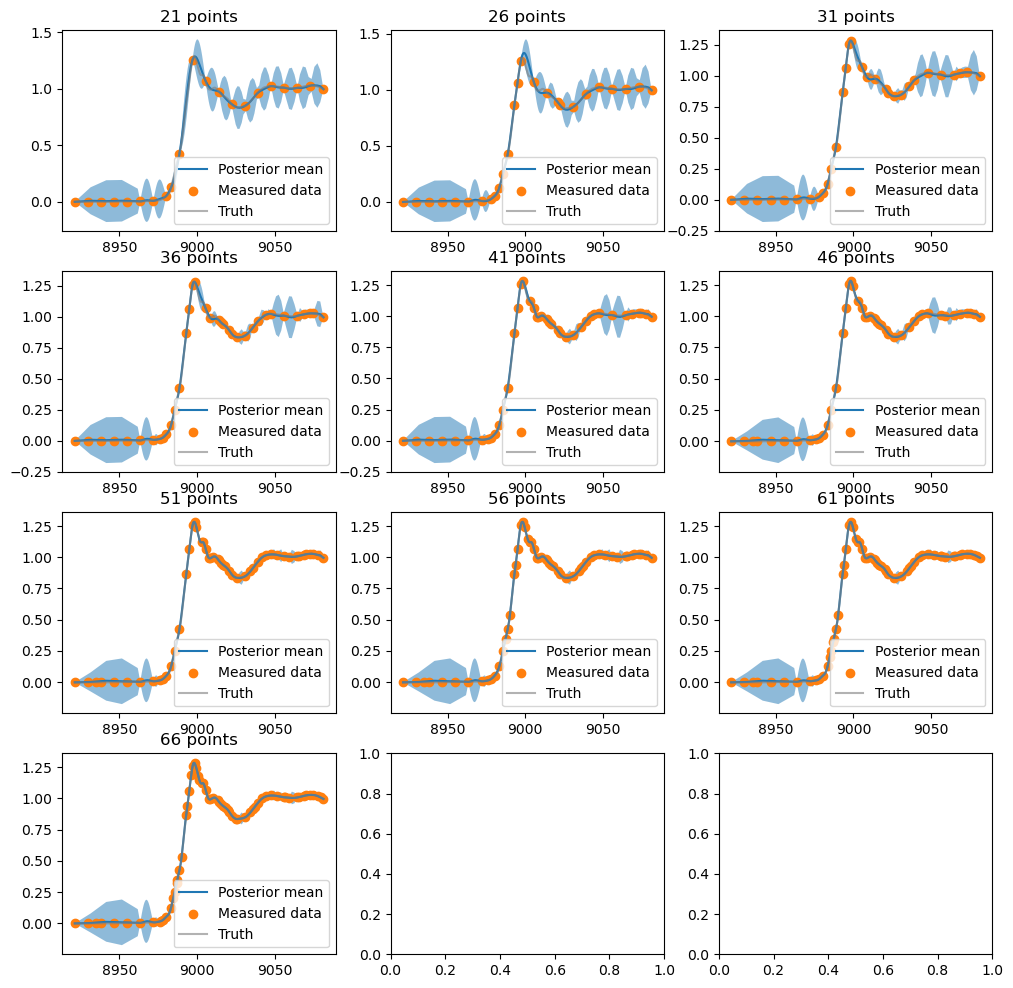

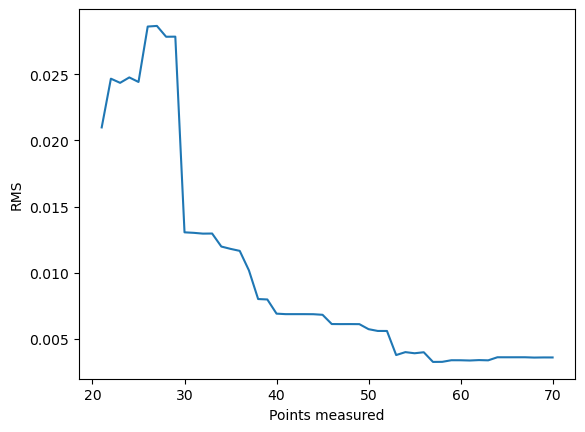

In [20]:
run_simulated_experiment(config, x_init, y_init, n_target_measurements=50)